In [6]:
import glob
import os
from lsst import afw
#print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth, create_combined_ITL_pointings
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+1


In [7]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)

mu = wavelengths_list[0]     # UV band
sigma = width_of_wavelength_list_converted[0]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
# plots the gaussians
weights = numpy.interp(wls, x, y)   

In [8]:
# loading all 5 position files
fname1= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-201.815_-10.575.fits"
fname2= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-201.815_9.785.fits"
fname3= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
fname4= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-221.815_-10.575.fits"
fname5= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-221.815_9.785.fits"
file_list = [fname1, fname2, fname3, fname4, fname5]

def create_ccob(img_list, i):
    num_ch = 16
    uv_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = file_list[i]     
    ccob_uv = get_ccd_from_id(None, file_list[i], [])

    # reading in files in CCOB testing at uv LED for each of 16 channels 
    for ch in range(num_ch):    
        uv = get_data_as_read(ccob_uv,ch + 1,["imaging"])["imaging"]    # QE data array for CCOBuv flat field image
        MEDIAN = numpy.median(uv)                                        # median (not mean, avoiding outliers) of QE data array for CCOBuv, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        uv_arr[ch] = uv
    return normedimg_arr, uv_arr

In [9]:
normedimg_arr_list = []
uv_arr_list = []

# independent of CCOB position, same img_list to create CCOBuv flat at every pointing
img_list = create_combined_ITL_pointings(superdarkpath, superbiaspath, qeflatpath, weights)    # create_combined returns img_list at end of function, DOES NOT DISPLAY FLAT

for i in range(len(file_list)):
    create_ccob(img_list, i)
    normedimg_arr, uv_arr = create_ccob(img_list, i)
    normedimg_arr_list.append(normedimg_arr)        
    uv_arr_list.append(uv_arr)

    
# finding a 2D array that is the average of the five pointings, each element in the normedimg_arr_list and uv_arr_list is itself a 2D array
normedimg_arr_avg = np.mean(np.array([normedimg_arr_list[0], normedimg_arr_list[1], normedimg_arr_list[2], normedimg_arr_list[3], normedimg_arr_list[4]]), axis=0)
uv_arr_avg = np.mean(np.array([uv_arr_list[0], uv_arr_list[1], uv_arr_list[2], uv_arr_list[3], uv_arr_list[4]]), axis=0)

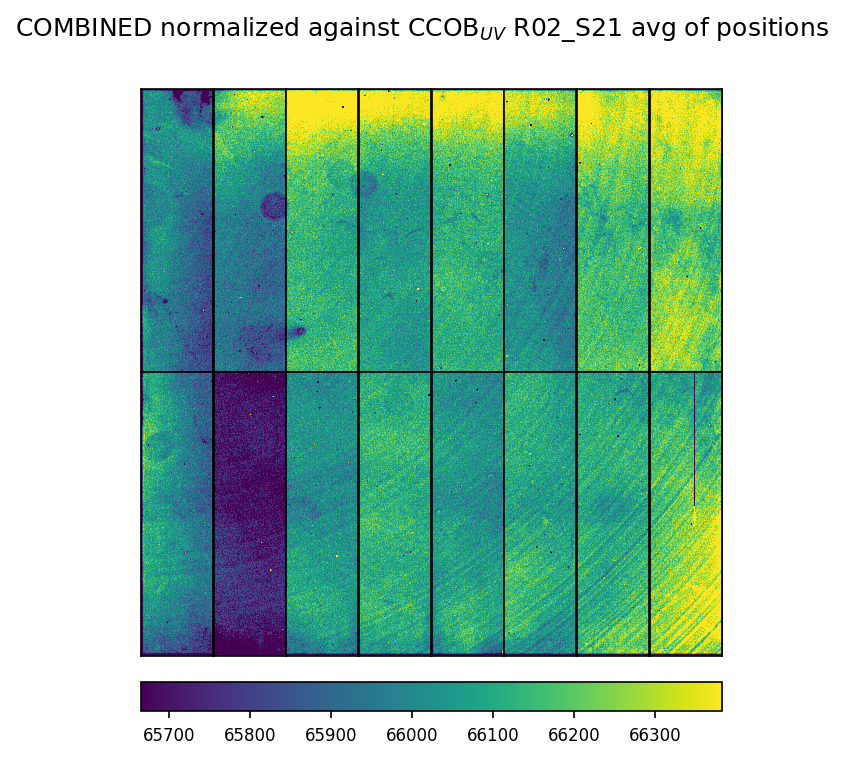

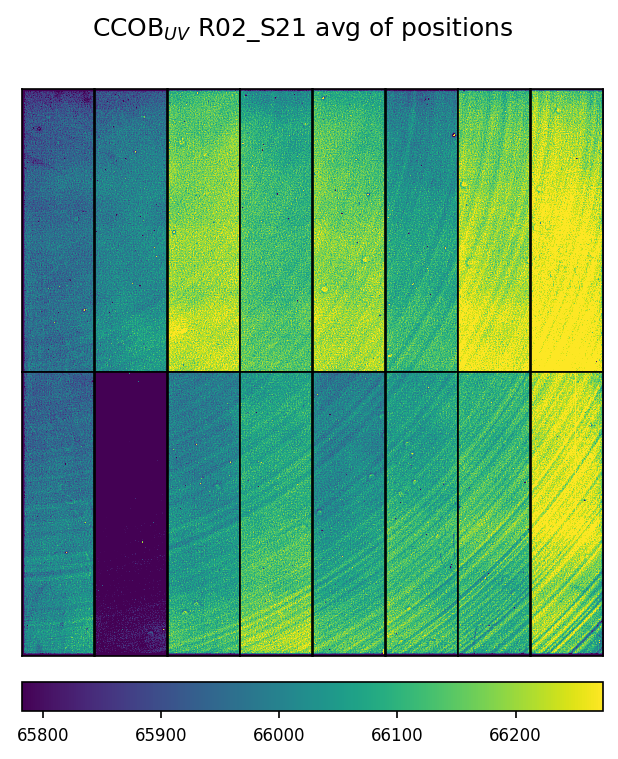

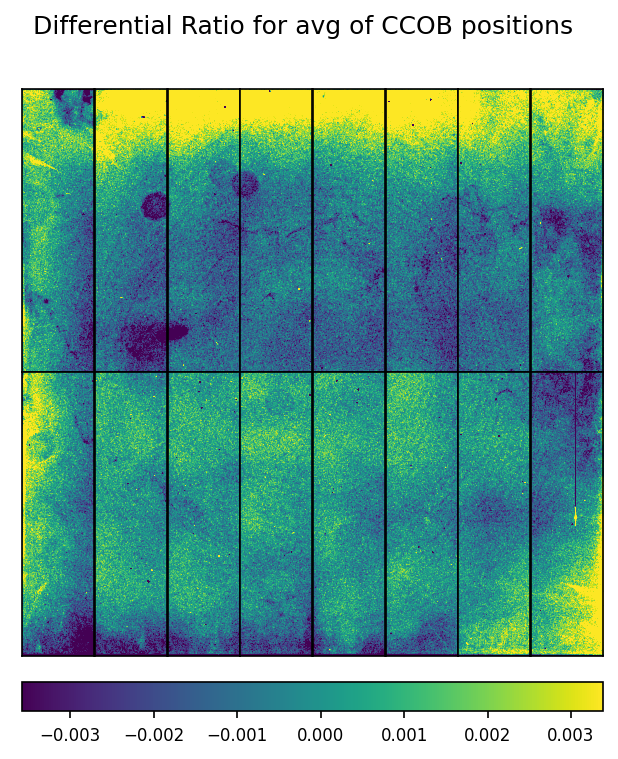

In [15]:
# default color map
num_ch = 16

# plot normalized, COMBINED flat
plotonesensor_ITL(normedimg_arr_avg, 'COMBINED normalized against CCOB$_{UV}$ R02_S21 avg of positions')

# plot CCOBred flat
plotonesensor_ITL(uv_arr_avg, 'CCOB$_{UV}$ R02_S21 avg of positions')

# plot Ratio flat, the one of interest!
diff_arr_avg = [None] * num_ch
for i in range(num_ch):
    diff_arr_avg[i] = (normedimg_arr_avg[i] - uv_arr_avg[i]) / uv_arr_avg[i]
plotonesensor_ITL(diff_arr_avg, 'Differential Ratio for avg of CCOB positions')